# Example: Multiple individual inference Schlögl model 

This notebook contains a tutorial on how to perform mult-individual inference for the Schlögl-model using PEPSDI. This notebook corresponds to the example presented in the paper. 

The Schlögl-data is simulated using the exact SSA-algorithm. 

To make the inference efficient the Langevin-approximation will be utlised for the inference (the number of molecules is high). Moreover, to account for the stochastic jumps a guided diffusion bridge filter is utlised for the pseudo-marginal inference, and particles are correlated to reduce the number of particles needed.

In [1]:
# To get all the directories correct the directory must be the root directory of the PEPSDI-cloned file 
cd("/home/sebpe/Dropbox/PhD/Projects/PEPSDI")

# Required packages for formulating a model and do inference 
using Distributions # For placing priors 
using Random # For setting seed 
using LinearAlgebra # For matrix operations 
using Plots
tmp = push!(LOAD_PATH, pwd() * "/Code") # Push PEPSDI into load-path 
using PEPSDI # Load PEPSDI 

## Defining the Schlögl SDE-model 

A SDE-model (Langevin) is defined by the SDE; $dX_t = \alpha \mathrm{d}t + \beta \mathrm{d} W_t$, the observation model $y_{mod} = h(x, t)$ and lastly the error model, $y_{obs} = g(\epsilon)$, $\epsilon \sim \pi_{\epsilon}(\xi)$. To perform inference all these have to be defined. That is, a SDE-model consists of a:

* Function for the drift alpha 
* Function for the diffusion matrix beta 
* Function to calculate initial values 
    * Since the initial values can be unknown making the used provide a function for the initial values allows these to be inferred 
* Function for the observation y (h)
* Function for the probability of observing y (g)

For the Schlögl-model it is assumed that $y = \mathbf{P}^TX + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \xi^2)$. For a linear observation model like this the particles in the particle-filter can be propagated using guided proposals. Here we used the modified diffusion bridge propagators (note that this requires that $\mathbf{P}$ is provided when creaing the SDE-model).  



In [2]:
# The drift vector need to have arguments du, u, p, t (simular to julia differential equations)
# du : alpha-vector (not allocating new du is efficient)
# u : current state-values 
# p : unknown model-quantites. p.c gives acces to individual parameters c, 
#     while p.kappa gives acces to cell-constants for multi-individual inference.  
# t : current time-value 
function schlogl_alpha(du, u, p, t)

    c = p.c
    kappa = p.kappa
    kappa3 = 23.1

    h_vec1 = kappa[1] * u[1] * (u[1] - 1)
    h_vec2 = kappa[2] * u[1] * (u[1] - 1) * (u[1] - 2)
    h_vec3 = c[1]
    h_vec4 = kappa3 * u[1]

    @views du[1] = h_vec1 - h_vec2 + h_vec3 - h_vec4
end

# The diffusion matrix has the same arguments as the drift-vector. However, here du = beta (diffusion matrix)
function schlogl_beta(du, u, p, t)
    c = p.c
    kappa = p.kappa
    kappa3 = 23.1
    
    h_vec1 = kappa[1] * u[1] * (u[1] - 1)
    h_vec2 = kappa[2] * u[1] * (u[1] - 1) * (u[1] - 2)
    h_vec3 = c[1]
    h_vec4 = kappa3 * u[1]

    @views du[1, 1] = h_vec1 + h_vec2 + h_vec3 + h_vec4
end


# The initial-value function needs to have the arguments u0, p
# u0 : vector with initial values (not allocating new du is efficient)
# p : as above (this allows initial values to be inferred)
function schlogl_u0!(u0, p) 
    u0[1] = 0.0
end


# The observation function y = g(X, p) must always have the arguments 
# y_mod, u, p, t
# y_mod : vector with model values at time t 
# u : state-values at time t
# p : as above (this allows y to depend on the parameters)
# t : current time-value 
function schlogl_h(y_mod, u, p, t)
    
    # g = X[1] -> y = X[1]
    y_mod[1] = u[1]
end


# The function for the probability to observe y_mod must always have the arguments 
# y_obs, y_mod, error_param, t, dim_obs. 
# y_obs : vector with observed values at time t (dimension = dim_obs)
# y_obs : vector with model values at time t (dimension = dim_obs)
# error_param : vector with error-parameters xi 
# t : current t-value 
# dim_obs, dimension of the observation vector y. 
function schlogl_g(y_obs, y_mod, error_param, t, dim_obs)
    
    # Since y_obs ~ N(y_mod, xi^2) the likelihood can be calculated 
    # via the normal distribution. Perform calculations on log-scale 
    # for stabillity. 
    prob::FLOAT = 0.0
    noise = error_param[1]
    error_dist = Normal(0.0, error_param[1])
    diff = y_obs[1] - y_mod[1]
    prob = logpdf(error_dist, diff)

    return exp(prob)
end


# P-matrix is the identity matrix here 
P_mat = [1]
sde_mod = init_sde_model(schlogl_alpha, 
                         schlogl_beta, 
                         schlogl_u0!, 
                         schlogl_h, 
                         schlogl_g, 
                         1,         # Model dimension dim(X)  
                         1,         # Dimension of observation model dim(Y)
                         P_mat) 

SdeModel{typeof(schlogl_alpha),typeof(schlogl_beta),typeof(schlogl_u0!),typeof(schlogl_h),typeof(schlogl_g),Int64,StaticArrays.SArray{Tuple{1,1},Float64,2,1},StaticArrays.SArray{Tuple{1,1},Float64,2,1}}(schlogl_alpha, schlogl_beta, schlogl_u0!, 1, schlogl_h, schlogl_g, 1, [1.0], [1.0])

## Defining inference options 

When we have a model we can perform the inference. However, before performing the inference we must specify inference options. These are 

* Distribution described by the population parameters $\eta$; $\mathbf{c}_i \sim \pi(\mathbf{c_i} | \eta)$
    * Details below. 
* Priors for the population parameters $\eta$, cell-constant parameter $\kappa$ and measurement error-parameters $\xi$.
    * Almost any distribution in the Julia distributions pacakge can be used for placing priors. 
    * Since the model does not have any cell-constant parameters $\kappa$ we do not have to use a priors here. 
* If the population, individual, and cell-constants parameters are inferred on log-scale, and if the parameters are constrained to be positive 
    * Performing inference on the log-scale means to infer $log(c)$ instead of $\mathbf{c}$. This can help explore the posterior more efficiently  (which is why we do it below) inference perspective. 
* Which particle filter to use for pseudo-marginal inference 
    * For the extrande-algorithm only a bootstrap filter can be used 
* If using PEPSDI-runnning option 2, how much $\kappa, \xi$ should vary between cells; $(\kappa_i, \xi_i) \sim \mathcal{N}\big( (\kappa_{pop}, \xi_{pop} ),  \epsilon \mathbf{I} \big), ε \ll 1 $ 
* Which adaptive mcmc-proposals scheme to propose $\kappa_i$, $\xi_i$ and $\mathbf{c}_i$ with.    
    * As noted in the paper, we found the RAM-sampler to be efficient. Thus, we use it below.  
* Location of data-file with observed data and where to save the results 

Since PEPSDI running option 2 (where $\kappa, \xi$ are allowed to vary weakly between cells) is fast we use it below. 

For the population parameters, we assume that $c_3 \sim \mathcal{LN}(\mu, \tau^2)$. This 
distribution can be seen as a special case of a multivariate log-normal distribution with a diagonal 
covariance matrix. This is one of the distributions PEPSDI currently supports and thus the one used below. 

In [3]:
# Prior for population parameters η = (μ, τ). Note, the priors can be almost any univariate distribution, 
# but they most be provided as arrays. 
prior_mean = [Normal(7.0, 10.0)]
prior_scale = [truncated(Cauchy(0.0, 2.5), 0.0, Inf)]

# Prior for strength of measurement error ξ
prior_sigma = [Normal(2.0, 0.5)]

# Prior for cell-constant parameters ĸ. Priors on log-scale 
# since we infer ĸ on the log-scale 
prior_kappa = [Normal(-1.0, 10.0), Normal(-3, 10.0)]
    
# Inference options for η, ĸ and ξ
pop_param_info = init_pop_param_info(prior_mean, 
                                     prior_scale, 
                                     prior_sigma, 
                                     prior_pop_kappa = prior_kappa, # ĸ not always used hence priors must be made explicit  
                                     pos_pop_kappa = false, # ĸ not constrained to positive  
                                     log_pop_kappa = true, # ĸ inferred on log-scale 
                                     pos_pop_sigma = true) # ξ inferred to be positive (and default not on log-scale)

# Set up opitons for individual parameters c_i
ind_val = [6.2] # Starting value for each individual 
ind_param_info = init_ind_param_info(ind_val,         # Starting value (can also be mean, median, random to sample prior)
                                     1,               # Number of individual parameters  
                                     log_scale=true,  # Individual parameters inferred on log-scale 
                                     pos_param=false) # Individual parameters not constrained to be positive 

# Choosing a particle filter 
dt = 5e-2 # Step-length when simulating the model 
rho = 0.999 # Correlation level between particles 
# Use the modified diffusion bridge filter 
filter_opt = init_filter(ModDiffusion(), dt, rho=rho)

# Choose adaptive mcmc-scheme when proposing parameters (ĸ_i, ξ_i) and c_i
cov_mat_ci = diagm([0.16])
cov_mat_kappa_sigma = diagm([0.25, 0.25, 0.5 / 10.0]) ./ 10
# As seen in the code multiple options can be provided for the RAM-sampler 
mcmc_sampler_ci = init_mcmc(RamSampler(), ind_param_info, cov_mat=cov_mat_ci, step_before_update=500)
mcmc_sampler_kappa_sigma = init_mcmc(RamSampler(), pop_param_info, cov_mat=cov_mat_kappa_sigma, step_before_update=500)

# Define the distributions for (ĸ_pop, ξ_pop) and η
pop_sampler_opt = init_pop_sampler_opt(PopNormalDiag(), n_warm_up=50) # η
# (ĸ_pop, ξ_pop) with ε = 0.01
kappa_sigma_sampler_opt = init_kappa_sigma_sampler_opt(KappaSigmaNormal(), variances = [0.01, 0.01 ,0.01]) # 

# Set up struct that stores all file-locations 
path_data = pwd() * "/Intermediate/Simulated_data/SSA/Multiple_ind/schlogl/schlogl.csv"
# Multiple_ind = true -> stored in intermediate under Multiple_individual folder
file_loc = init_file_loc(path_data, "Example/Schlogl_model", multiple_ind=true) 

As cauchy distribution is used will change to median for init-param


FileLocations{Array{String,1},Array{Float64,1},Array{Int64,1}}("/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Simulated_data/SSA/Multiple_ind/schlogl/schlogl.csv", "Example/Schlogl_model", "/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Multiple_individuals/Example/Schlogl_model", [""], Float64[], [1])

## Perform pilot run 

To perform efficient pseduo-marginal inference we want to take as many samples as possible, without risking that the chain gets stuck. As noted in the paper this can be achieved if we tune the number of particles. 

A often using tuning approach is to first run a pilot-run to end up in a central posterior location. From this central location the particles can then be tuned according to tuning criteria (see paper supplementary 5.2). 

Many particles should be used in the pilot-run to prevent the mcmc-chain from getting stuck. 

PEPSDI will write the number of particles calculated by the tuning scheme, the tuned adaptive mcmc options, 
and the end-location of the pilot run to disk. Furthermore, to avoid having to re-run a pilot run PEPSDI writes the pilot-run options to disk 

The results from the pilot run is stored in *Intermediate/Multiple_individual/Name_in_file_loc*. For more detail see the tutorial notebook. 

In [4]:
# Set up options for pilot-run 
tune_part_data = init_pilot_run_info(pop_param_info, # Population parameter information 
                                     n_particles_pilot=500, # Number of particles per individual in pilot-run 
                                     n_samples_pilot=5000,  # Number of samples pilot-run  
                                     rho_list=[0.999],      # Correlation level pilot-run 
                                     n_times_run_filter=50, # Number of times to run filter when tuning 
                                     init_kappa=log.([1.8e-1, 2.5e-4])) # Initial values for ĸ_pop pilot run 

# Tune particles for PEPSDI running option 2 
tune_particles_opt2(tune_part_data, pop_param_info, ind_param_info, 
        file_loc, sde_mod, filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt)

As cauchy distribution is used will change to median for init-param
Starting tuning of particles using alternative sampler
Running pilot run
n_individuals = 40
Starting to calculate likelihood
Log-likelihood starting value = -69026.953


Running sampler...100%|█████████████████████████████████| Time: 4:15:21m


Tuning particles for rho = 0.999
[7.0]
[7.150045855763043]
[10, 10, 50, 20, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 20, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10]
Done


## Perform main run 

After the pilot-run the main inference run can be performed. Since the pilot-run, hopefully, arrived at a mode a good starting location is the end-location of the pilot run. 

For the inference inference the end-point of the pilot-run, the adaptive mcmc-sampler options, and the number of particles can be read from disk (since PEPSDI saved these at the end of the pilot run). To do this, notice that each unique pilot-run is equipped with an experimental id (exp_id/exp_tag), this can be used to load the particles from a particular run (see below). Here, we provide exp_tag = 1 to load results from the above pilot run when doing the inference.   

In [5]:
# Use 50,000 samples to avoid to long run-time 
exp_id = 1
n_samples = 50000
tmp = run_PEPSDI_opt2(n_samples, pop_param_info, ind_param_info, file_loc, sde_mod, 
        filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt, pilot_id=exp_id)
status = "done"
print("Done")


[7.0]
[7.150045855763043]
Starting to calculate likelihood
Log-likelihood starting value = -23220.386


Running sampler...100%|█████████████████████████████████| Time: 1:24:56


["c1", "id"]
Running posterior visual check...Running pvc none-quantile
Running pvc quantile
done
Done

## Plot the inference results

The red-line corresponds to the true-value, highlighting that PEPSDI accurately infers the true parameters values. 

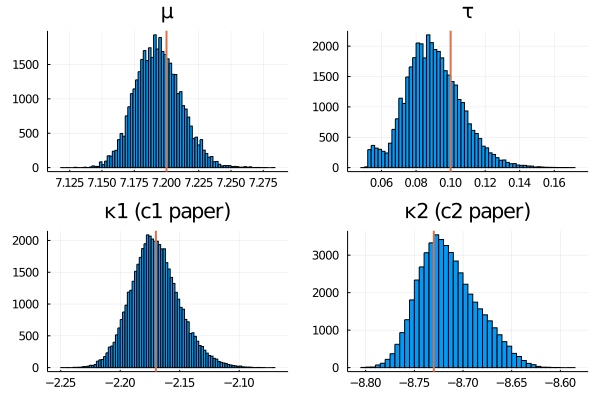

In [7]:

mcmc_chains = tmp[1]

p1 = histogram(mcmc_chains.mean[1, 10000:end], title = "µ", label=false)
vline!([7.2], lw = 2, label=false)

p2 = histogram(mcmc_chains.scale[1, 10000:end], title = "τ", label=false)
vline!([0.1], lw = 2, label=false)

p3 = histogram(mcmc_chains.kappa_sigma[1, :], title = "ĸ1 (c1 paper)", label=false)
vline!([-2.17], lw = 2, label=false)

p4 = histogram(mcmc_chains.kappa_sigma[2, :], title = "ĸ2 (c2 paper)", label=false)
vline!([-8.73], lw = 2, label=false)

l = @layout [a b; b c]
plot(p1, p2, p3, p4, layout = l)
